In [1]:
from UTILITY_quickstart import *

In [2]:
#Start from the golden lattice, but with the injector reconfigured to the standard for 2024-10-22_oneBunch
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_injectorOnly.yml")

In [3]:
csrTF = False
evalElement = "PENT"
#evalElement = "BEGPDC"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)



Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_17561250815101271841.h5, and reinit to tao


## Starting point

In [ ]:
### Scan

-44


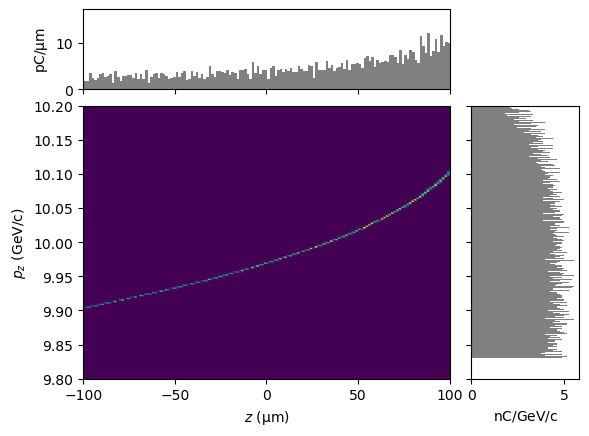

Slope: 8.791e+11
R²: 0.9046676284902296
-43


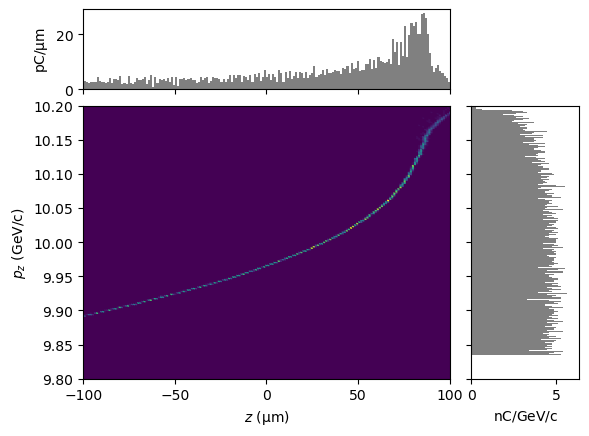

Slope: 1.056e+12
R²: 0.8751224257948746
-42


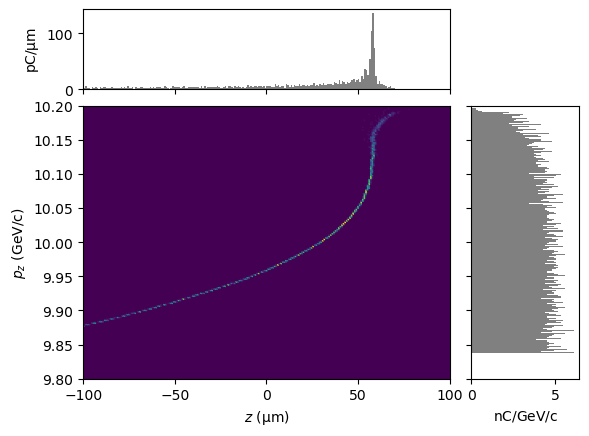

Slope: 1.312e+12
R²: 0.8211935772926959
-41


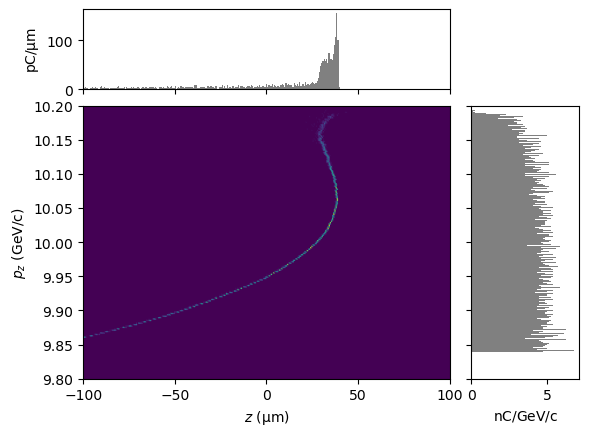

Slope: 1.678e+12
R²: 0.7068609844172515
-40


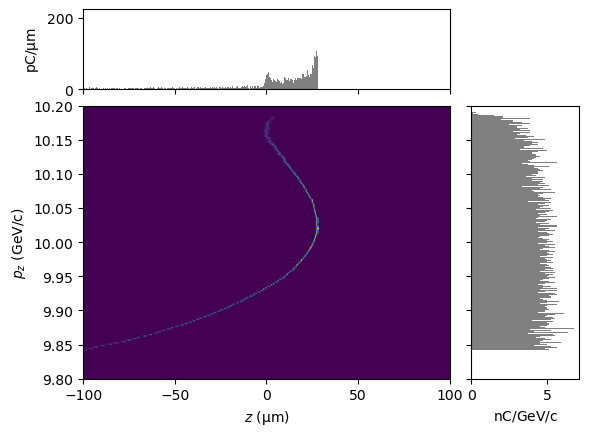

Slope: 1.970e+12
R²: 0.4256774858708207
-39


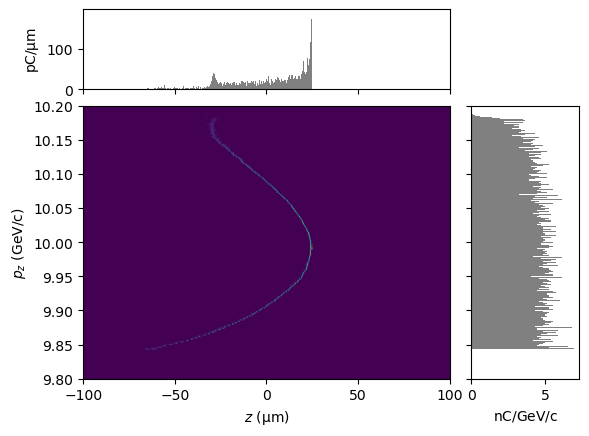

Slope: 1.907e+11
R²: 0.001950653613673291
-38


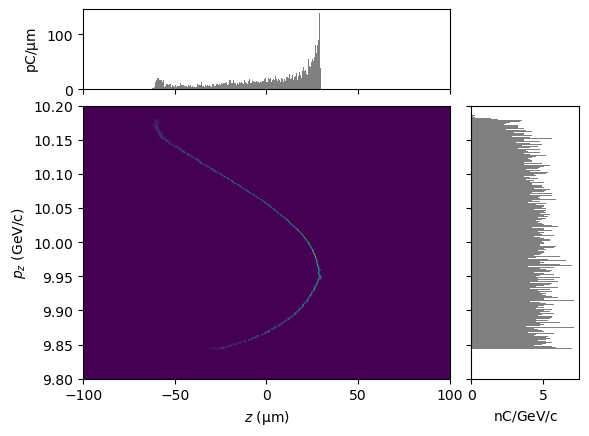

Slope: -2.337e+12
R²: 0.45559054091682905
-37


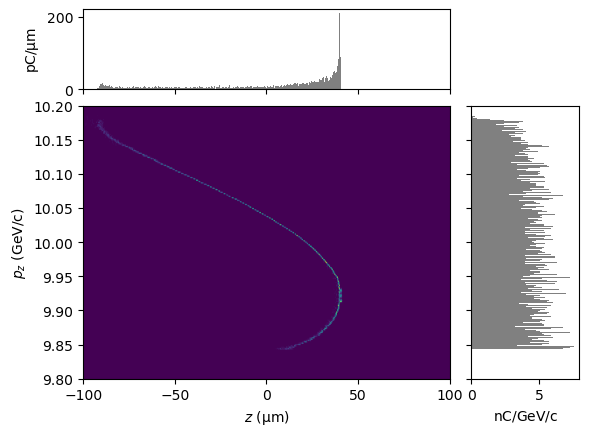

Slope: -2.020e+12
R²: 0.8027256477802183


In [8]:
#Informed by https://docs.google.com/presentation/d/1wyOVL2_KEICl01ousdltTvDWa7sZ43WoDjAZRu9I2c4/edit#slide=id.g335837a1eaf_0_45 , by hand pick L1 and L2 that gives ~full compression with golden lattice

from scipy.stats import linregress

for L2PhaseSet in np.arange(-44, -36, 1):
    print(L2PhaseSet) 
    
    importedDefaultSettings = (importedDefaultSettings | {"L1PhaseSet" : -22, "L2PhaseSet" : L2PhaseSet})
    
    setLattice(tao, **importedDefaultSettings)
    trackBeam(tao,  **importedDefaultSettings)
    
    P = getBeamAtElement(tao, "PENT")
    
    display(plotMod(P, 'z', 'pz', bins=300, xlim = (-100e-6, 100e-6), ylim = (9.8e9, 10.2e9) ) )
    plt.clf()
    
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(P.z, P.energy)
    
    # r_value**2 is the R²
    r_squared = r_value**2
    
    print(f"Slope: {slope:.3e}")
    print(f"R²: {r_squared}")

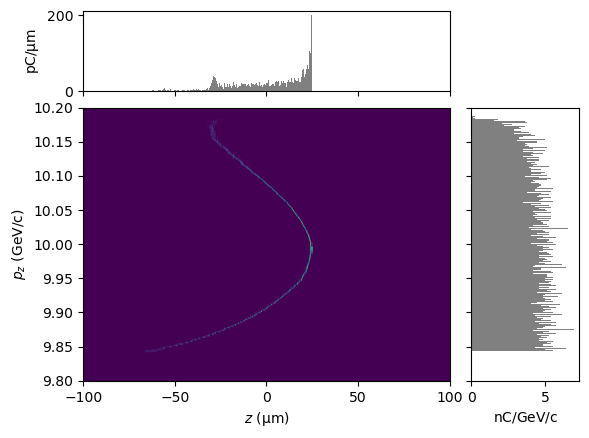

Slope: 1.953e+11
R²: 0.0020437846265403425


In [9]:
# -39 doesn't look conventionally good, but I think it's the correct working point to optimize from
importedDefaultSettings = (importedDefaultSettings | {"L1PhaseSet" : -22, "L2PhaseSet" : -39})

setLattice(tao, **importedDefaultSettings)
trackBeam(tao,  **importedDefaultSettings)

P = getBeamAtElement(tao, "PENT")

display(plotMod(P, 'z', 'pz', bins=300, xlim = (-100e-6, 100e-6), ylim = (9.8e9, 10.2e9) ) )
plt.clf()


# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(P.z, P.energy)

# r_value**2 is the R²
r_squared = r_value**2

print(f"Slope: {slope:.3e}")
print(f"R²: {r_squared}")

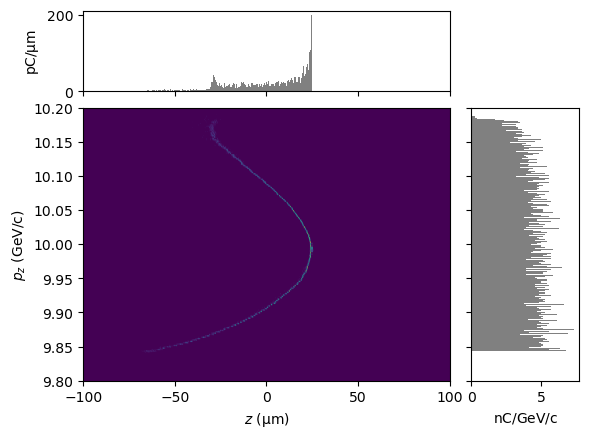

In [10]:
PStart = getBeamAtElement( tao, "BEGBC20" ) 

makeBeamActiveBeamFile(PStart, tao = tao)

trackBeam(tao, trackStart = "BEGBC20", **importedDefaultSettings)

P = getBeamAtElement(tao, "PENT")

display(plotMod(P, 'z', 'pz', bins=300, xlim = (-100e-6, 100e-6), ylim = (9.8e9, 10.2e9) ) )

## Hand tune

In [11]:
#Defaults:
# S1ELkG :  804.871
# S2ELkG :  -2049.489
# S3ELkG :  -1019.3230 

importedDefaultSettings["symmetricSextupoleStrengths"]

True

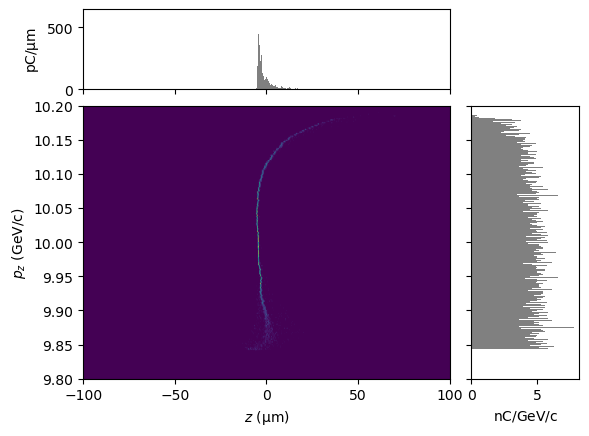

7.765532411443867e-06
9.043294931373994e-06
6.583592334611241e-06
4.396822124739308e-06


In [17]:
#RMS optimized: [    9.64535719 -4257.21556568 -2590.09249858]
#SI90 optimized: [ 1.11394347e+00 -4.58169980e+03 -2.56313841e+03]

setLattice(tao, **(importedDefaultSettings  | {
    "S1ELkG" : 1, #800, #1300
    "S2ELkG" : -4580, #-2000,
    "S3ELkG" : -2560, #-2000
} ) )

trackBeam(tao, trackStart = "BEGBC20", **importedDefaultSettings)

P = getBeamAtElement(tao, "PENT")

display(plotMod(P, 'z', 'pz', bins=300, xlim = (-100e-6, 100e-6), ylim = (9.8e9, 10.2e9) ) )

print( P["sigma_z"] ) 
print( smallestIntervalImpliedSigma(P.z, percentage = 0.99) ) 
print( smallestIntervalImpliedSigma(P.z, percentage = 0.95) ) 
print( smallestIntervalImpliedSigma(P.z, percentage = 0.90) ) 

In [16]:
#Try using the actual RMS as the objective (instead of the typical SI90) to more agressively force it to fix the curve (RMS makes it "care" about the tails a lot)
def objective(params):
    S1ELkG, S2ELkG, S3ELkG = params
    
    setLattice(tao, **(importedDefaultSettings  | {
        "S1ELkG" : S1ELkG,
        "S2ELkG" : S2ELkG,
        "S3ELkG" : S3ELkG,
    } ) )
    
    trackBeam(tao, trackStart = "BEGBC20", **importedDefaultSettings)
    
    P = getBeamAtElement(tao, "PENT")

    #error = P["sigma_z"]
    error = smallestIntervalImpliedSigma(P.z, percentage = 0.90)

    print( params, error ) 
    
    return error


from scipy.optimize import minimize


# Perform optimization using Nelder-Mead
# result = minimize(
#     objective, 
#     [1000, -1000, -1000],# [1300, -2000, -1000], #Starting point
#     bounds = [(0,2590), (-21706,0), (-2625, 0)],
    
#     method='Nelder-Mead',
#     options={'adaptive': True}

#     # method = "COBYQA",
#     # options = {
#     #     "scale": True, 
#     #     #"initial_tr_radius": 1e-1, #1e-1
#     #     #"final_tr_radius": 1e-8, 
#     #     "disp": True } #"*_tr_radius" appears to constrain the scaled, not raw, variables (if scaling is enabled)
# )

from scipy.optimize import differential_evolution

result = differential_evolution(
    objective,
    bounds = [(0,2590), (-21706,0), (-2625, 0)]
)



print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")

[  831.24882716 -1140.38392269  -229.29862048] 2.5372677308167082e-05
[  1698.94657327 -14194.04639603   -144.08659671] 4.686110697322147e-05
[  973.40742969 -9583.02205578 -2352.96225581] 2.64628190364425e-05
[ 2088.15387852 -6763.1936235  -1087.51883495] 8.767945608188261e-06
[   980.72592997 -20922.9074711   -1519.48157945] 4.20681908817036e-05
[ 2396.74408031 -3907.67714536 -2323.27684217] 1.3058116229536711e-05
[ 2024.27758185 -5032.64928054 -1759.18725272] 1.1054351118612464e-05
[   409.09445899 -15337.05293059  -1226.53097022] 4.77251588211701e-05
[ 2584.41259355 -3380.37173236  -387.16191299] 1.4453026475657253e-05
[ 2312.42159203 -8578.67291315 -1853.01024595] 2.074598652023479e-05
[   32.68730124  -865.96170622 -2051.94791649] 2.5045388003993777e-05
[  2135.70826509 -12438.56634339  -1388.93014146] 3.666682328424683e-05
[  1836.55485194 -11497.54479722  -1678.24467314] 3.1744276738902755e-05
[  208.85856972 -2122.10652932 -2528.34639023] 1.3908489769656451e-05
[  481.51013465